In [1]:
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, TensorDataset, ConcatDataset
import numpy as np
import matplotlib.pyplot as plt
import yaml
from tqdm import tqdm
import torchvision.transforms.v2 as v2
from copy import deepcopy
import sys
sys.path.append("/n/home11/sambt/phlab-neurips25")

device = 'cuda' if torch.cuda.is_available() else 'cpu'

from models.litmodels import SimCLRModel
from models.networks import CustomResNet, MLP
from models.losses import MMDLoss, RBF
from data.datasets import CIFAR10Dataset
from data.cifar import CIFAR5MDataset
import data.data_utils as dutils

from sklearn.metrics import roc_auc_score, top_k_accuracy_score
from utils.plotting import make_corner

/n/holystore01/LABS/iaifi_lab/Users/sambt/mamba/envs/torch_gpu/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
from data.datasets import JetClassDataset
dset = JetClassDataset(["qcd","ttbar","wqq","zqq","hbb"],
                       "/n/home11/sambt/phlab-neurips25/configs/jetclass_data_configs/JetClass_full.yaml",
                       limit_test_files=1,
                       batch_size=512,
                       num_workers=1)

In [3]:
# T = 0.1
checkpoint = "/n/home11/sambt/phlab-neurips25/runs/jetClass_parT_simCLR_T0.1_withClassifier/lightning_logs/572ll2g9/checkpoints/epoch=11-step=1200.ckpt"
model = SimCLRModel.load_from_checkpoint(checkpoint)
model = model.eval()
model = model.to(device)

test_loader = dset.test_dataloader()

cfg_block: {'embed_dim': 128, 'num_heads': 8, 'ffn_ratio': 4, 'dropout': 0.1, 'attn_dropout': 0.1, 'activation_dropout': 0.1, 'add_bias_kv': False, 'activation': 'gelu', 'scale_fc': True, 'scale_attn': True, 'scale_heads': True, 'scale_resids': True}
cfg_cls_block: {'embed_dim': 128, 'num_heads': 8, 'ffn_ratio': 4, 'dropout': 0, 'attn_dropout': 0, 'activation_dropout': 0, 'add_bias_kv': False, 'activation': 'gelu', 'scale_fc': True, 'scale_attn': True, 'scale_heads': True, 'scale_resids': True}


/n/holystore01/LABS/iaifi_lab/Users/sambt/mamba/envs/torch_gpu/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'encoder' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['encoder'])`.
/n/holystore01/LABS/iaifi_lab/Users/sambt/mamba/envs/torch_gpu/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'projector' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['projector'])`.


In [4]:
n_processed = 0
n_per_class = {}
all_embeddings = []
all_labels = []
for batch in tqdm(test_loader):
    x, labels, observers = batch
    labels = labels['_label_'].numpy()
    for k in x.keys():
        x[k]=x[k].to(device)
    with torch.no_grad():
        embeds = model.encoder(x).cpu().numpy()
    del x
    torch.cuda.empty_cache()
    all_embeddings.append(embeds)
    all_labels.append(labels)

0it [00:00, ?it/s]/n/holystore01/LABS/iaifi_lab/Users/sambt/mamba/envs/torch_gpu/lib/python3.10/site-packages/torch/nn/functional.py:5193: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
977it [05:34,  2.92it/s]


In [5]:
all_embeddings = np.concatenate(all_embeddings)
all_labels = np.concatenate(all_labels)
np.savez("jetClass_embeddings_T0.1.npz",data=all_embeddings,labels=all_labels)

In [6]:
# T = 0.5
checkpoint = "/n/home11/sambt/phlab-neurips25/runs/jetClass_parT_simCLRWithClassifier_T0.5/lightning_logs/4kau78ed/checkpoints/epoch=28-step=2900.ckpt"
model = SimCLRModel.load_from_checkpoint(checkpoint)
model = model.eval()
model = model.to(device)

test_loader = dset.test_dataloader()

cfg_block: {'embed_dim': 128, 'num_heads': 8, 'ffn_ratio': 4, 'dropout': 0.1, 'attn_dropout': 0.1, 'activation_dropout': 0.1, 'add_bias_kv': False, 'activation': 'gelu', 'scale_fc': True, 'scale_attn': True, 'scale_heads': True, 'scale_resids': True}
cfg_cls_block: {'embed_dim': 128, 'num_heads': 8, 'ffn_ratio': 4, 'dropout': 0, 'attn_dropout': 0, 'activation_dropout': 0, 'add_bias_kv': False, 'activation': 'gelu', 'scale_fc': True, 'scale_attn': True, 'scale_heads': True, 'scale_resids': True}


/n/holystore01/LABS/iaifi_lab/Users/sambt/mamba/envs/torch_gpu/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'classifier' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['classifier'])`.


In [7]:
n_processed = 0
n_per_class = {}
all_embeddings = []
all_labels = []
for batch in tqdm(test_loader):
    x, labels, observers = batch
    labels = labels['_label_'].numpy()
    for k in x.keys():
        x[k]=x[k].to(device)
    with torch.no_grad():
        embeds = model.encoder(x).cpu().numpy()
    del x
    torch.cuda.empty_cache()
    all_embeddings.append(embeds)
    all_labels.append(labels)

977it [03:21,  4.85it/s]


In [8]:
all_embeddings = np.concatenate(all_embeddings)
all_labels = np.concatenate(all_labels)
np.savez("jetClass_embeddings_T0.5.npz",data=all_embeddings,labels=all_labels)

# train supervised classifier T = 0.1

In [15]:
from sklearn.model_selection import train_test_split
data = np.load("jetClass_embeddings_T0.1.npz")
bkg = data['data'][data['labels'] != 4]
sig = data['data'][data['labels'] == 4]
np.random.shuffle(bkg)
np.random.shuffle(sig)

bkg_train, bkg_test = train_test_split(bkg,test_size=0.5)
sig_train, sig_test = train_test_split(sig,test_size=0.5)

train_data = np.concatenate([bkg_train[:len(sig_train)],sig_train],axis=0)
train_labels = np.concatenate([np.zeros(len(bkg_train[:len(sig_train)])),np.ones(len(sig_train))]).reshape(-1,1)
perm = np.random.permutation(len(train_data))
train_data = train_data[perm]
train_labels = train_labels[perm]

train_data, val_data, train_labels, val_labels = train_test_split(train_data,train_labels,test_size=0.1)

train_dset = TensorDataset(torch.tensor(train_data),torch.tensor(train_labels))
val_dset = TensorDataset(torch.tensor(val_data),torch.tensor(val_labels))
train_loader = DataLoader(train_dset,batch_size=512,shuffle=True)
val_loader = DataLoader(val_dset,batch_size=512,shuffle=True)

100%|██████████| 50/50 [01:15<00:00,  1.52s/it]


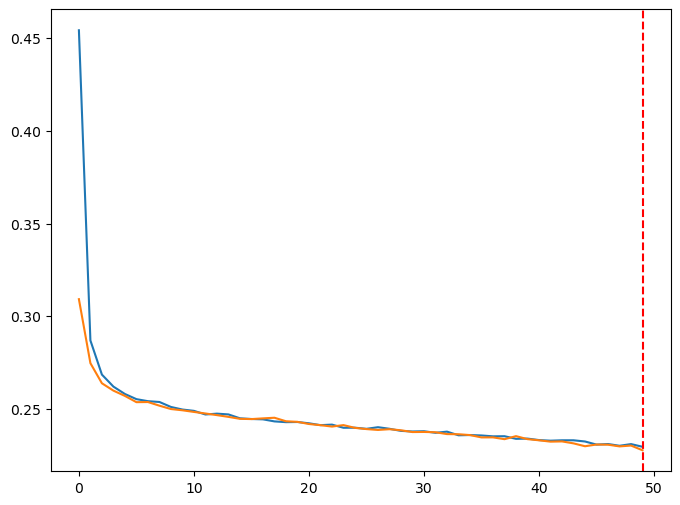

In [18]:
model = MLP(train_data.shape[1],[32,32,16],1,dropout=0.1).to(device)
num_epochs = 50
lr = 1e-3
optimizer = torch.optim.AdamW(model.parameters(),lr=lr)

train_loss = []
val_loss = []
best_loss = 1e6
best_state = None
best_ep = None
patience = 0
patience_lim = 10
for i in tqdm(range(num_epochs)):
    tlosses = []
    if patience == patience_lim:
        print('stopped improving')
        break
    for batch in train_loader:
        x,lab = batch
        preds = model(x.to(device))
        loss = F.binary_cross_entropy_with_logits(preds,lab.to(device))
        tlosses.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_loss.append(np.mean(tlosses))
    
    vlosses = []
    for batch in train_loader:
        x,lab = batch
        with torch.no_grad():
            preds = model(x.to(device))
        loss = F.binary_cross_entropy_with_logits(preds,lab.to(device))
        vlosses.append(loss.item())
    val_loss.append(np.mean(vlosses))
    if val_loss[-1] < best_loss:
        best_loss = val_loss[-1]
        best_state = model.state_dict()
        best_ep = i
        patience = 0
    else:
        patience += 1

plt.figure(figsize=(8,6))
x = np.arange(len(train_loss))
plt.plot(x,train_loss,label='train')
plt.plot(x,val_loss,label='val')
plt.axvline(best_ep,linestyle='--',color='red')

In [19]:
model.load_state_dict(best_state)
model = model.eval()

In [20]:
torch.save(model,"jetClass_supClassifier_T0.1.pt")

In [24]:
act = nn.Sigmoid()
bkg_test_preds = []
for x, in DataLoader(TensorDataset(torch.tensor(bkg_test)),batch_size=512,shuffle=False):
    with torch.no_grad():
        bkg_test_preds.append(act(model(x.to(device))).cpu().numpy())
bkg_test_preds = np.concatenate(bkg_test_preds)

sig_test_preds = []
for x, in DataLoader(TensorDataset(torch.tensor(sig_test)),batch_size=512,shuffle=False):
    with torch.no_grad():
        sig_test_preds.append(act(model(x.to(device))).cpu().numpy())
sig_test_preds = np.concatenate(sig_test_preds)

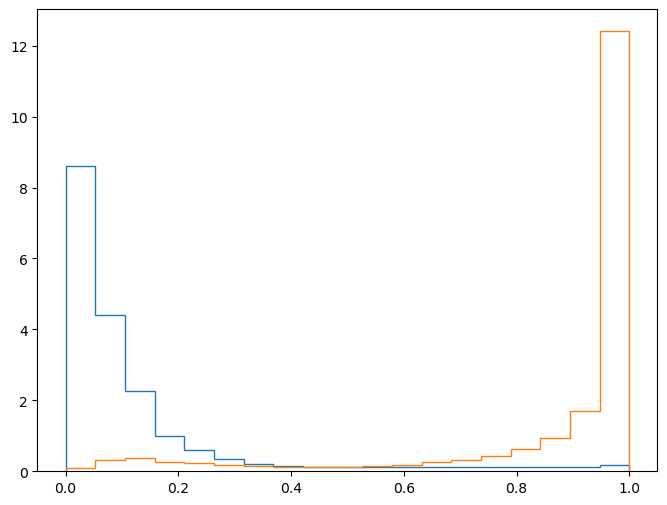

In [28]:
plt.figure(figsize=(8,6))
bins = np.linspace(0,1,20)
h1 = plt.hist(bkg_test_preds[:,0],bins=bins,density=True,histtype='step')
h1 = plt.hist(sig_test_preds[:,0],bins=bins,density=True,histtype='step')

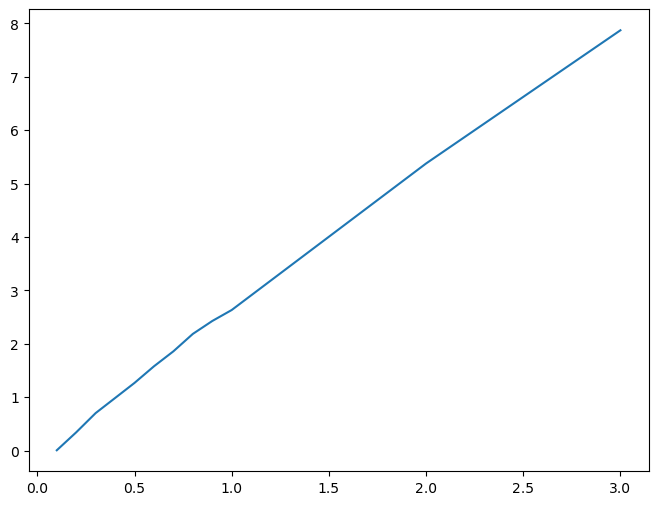

In [34]:
from scipy.stats import ks_2samp, norm
bkg_ref = bkg_test_preds[:50000,0]
bkg_inj = bkg_test_preds[50000:100000,0]

sig_fracs = [0.001,0.002,0.003,0.004,0.005,0.006,0.007,0.008,0.009,
             0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,
             0.1,0.15,0.2]
pvalues = []
zscores = []
for sf in sig_fracs:
    sig_sel = np.random.choice(sig_test_preds[:,0],size=int(sf*len(bkg_inj)),replace=False)
    tot = np.concatenate([bkg_inj,sig_sel])
    res = ks_2samp(bkg_ref,tot)
    pvalues.append(res.pvalue)
    zscores.append(norm.ppf(1-res.pvalue))

plt.figure(figsize=(8,6))
plt.plot(100*np.array(sig_fracs),zscores)

In [35]:
np.savez("jetClass_T0.1_idealZscores_ks2sided_nref50k_nbkg50k.npz",zscores=np.array(zscores),fracs=np.array(sig_fracs))